In [57]:
import numpy as np
import cplex
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
class Subproblem_LP():
    def __init__(self):
        self.n_dim = (n_stage - 1) * n_job * n_job
        self.n_constraints = 2 * (n_stage - 1) * n_job
        self.variable_names = ['x'+ str(i) for i in range(self.n_dim)]
        self.constraints_rows = self.set_constraints_byrows()
        self.opt_solution = np.random.randint(0,2,size = self.n_dim) 
        self.rhs = [1] * self.n_constraints
        self.senses = 'E'* self.n_constraints

    def set_job_to_position(self):
        job_to_position_onlyone = []
        for i in range((n_stage - 1) * n_job):
            job_to_position_onlyone.append([self.variable_names[i * n_job : (i + 1) * n_job], [1] * n_job])
        return job_to_position_onlyone
    
    def set_position_to_job(self):
        position_to_job_onlyone = []
        for j in range(n_stage - 1):
            for i in range(n_job):
                position_to_job_onlyone.append([self.variable_names[j * (n_job**2) + i: (j + 1) * (n_job**2): n_job], [1] * n_job])
        return position_to_job_onlyone
    
    def set_constraints_byrows(self):
        job_to_position_onlyone = self.set_job_to_position()
        position_to_job_onlyone = self.set_position_to_job()
        return job_to_position_onlyone + position_to_job_onlyone
    
    def compute_obj(self, tval, lamd):
        x_coeff_f4 = self.compute_f4_x(lamd)
        x_coeff_F6 = self.compute_F6_x(tval, lamd)
        x_coeff = [0 for i in range((n_stage - 1) * n_job * n_job)]
        for i in range(n_job):
            for j in range(n_stage-1):
                for r in range(n_batch * pcast):
                    for k in range(n_machine_perstage):
                        for i1 in range(n_job):
                            t2 = i * n_job + j * n_job * n_job + k * n_batch * pcast + r
                            x_coeff[t2] = x_coeff_f4[t2] - x_coeff_F6[t2]
        self.obj_coeff = x_coeff
        return self.obj_coeff
    
    def compute_F6_x(self, tval, lamd):
        x_coeff = [0 for i in range((n_stage - 1) * n_job * n_job)]
        for i in range(n_job):
            for j in range(n_stage - 1):
                t1 = i + j * n_job
                for r in range(n_batch * pcast):
                    for k in range(n_machine_perstage):
                        t2 = i * n_job + j * n_job * n_job + k * n_batch * pcast + r
                        for i1 in range(n_job):
                            if i1 != i:
                                if r == n_batch * pcast - 1:
                                    t3 = i1 + i * n_job + j * n_job * n_job
                                    t4 = i1 * n_job + j * n_job * n_job + k * n_batch * pcast + r - 1 
                                    t5 = i1 + j * n_job
                                    x_coeff[t2] += lamd[t3] * ((0.5 * ((self.opt_solution[t2] + self.opt_solution[t4])**2 - self.opt_solution[t2] - self.opt_solution[t4]) + tval[t1] -  tval[t5]) * (self.opt_solution[t2] + self.opt_solution[t4] - 0.5) - 0.5 * (2 * processtime[t5] + 1) * (self.opt_solution[t4] - self.opt_solution[t2]))           
                                elif r == 0:
                                    t3 = i + i1 * n_job + j * n_job * n_job
                                    t4 = i1 * n_job + j * n_job * n_job + k * n_batch * pcast + r + 1
                                    t5 = i1 + j * n_job
                                    x_coeff[t2] += lamd[t3] * ((0.5 * ((self.opt_solution[t2] + self.opt_solution[t4])**2 - self.opt_solution[t2] - self.opt_solution[t4]) + tval[t5] -  tval[t1]) * (self.opt_solution[t2] + self.opt_solution[t4] - 0.5) + 0.5 * (2 * processtime[t1] + 1) * (self.opt_solution[t2] - self.opt_solution[t4]))                                       
                                else:
                                    t3 = i + i1 * n_job + j * n_job * n_job
                                    t4 = i1 * n_job + j * n_job * n_job + k * n_batch * pcast + r + 1
                                    t5 = i1 + j * n_job
                                    t6 = i1 + i * n_job + j * n_job * n_job
                                    t7 = i1 * n_job + j * n_job * n_job + k * n_batch * pcast + r - 1
                                    x_coeff[t2] += lamd[t3] * ((0.5 * ((self.opt_solution[t2] + self.opt_solution[t4])**2 - self.opt_solution[t2] - self.opt_solution[t4]) + tval[t5] -  tval[t1]) * (self.opt_solution[t2] + self.opt_solution[t4] - 0.5) + 0.5 * (2 * processtime[t1] + 1) * (self.opt_solution[t2] - self.opt_solution[t4]))
                                    x_coeff[t2] += lamd[t6] * ((0.5 * ((self.opt_solution[t2] + self.opt_solution[t7])**2 - self.opt_solution[t2] - self.opt_solution[t7]) + tval[t1] -  tval[t5]) * (self.opt_solution[t2] + self.opt_solution[t7] - 0.5) - 0.5 * (2 * processtime[t5] + 1) * (self.opt_solution[t7] - self.opt_solution[t2]))           
        
        return x_coeff
    
    def compute_f4_x(self, lamd):
        x_coeff = [0 for i in range((n_stage - 1) * n_job * n_job)]
        for i in range(n_job):
            for j in range(n_stage - 1):
                t1 = i + j * n_job
                for r in range(n_batch * pcast):
                    for k in range(n_machine_perstage):
                        t2 = i * n_job + j * n_job * n_job + k * n_batch * pcast + r
                        for i1 in range(n_job):
                            if i1 != i:
                                if r == n_batch * pcast - 1 or r == 0:
                                    t3 = i + i1 * n_job + j * n_job * n_job
                                    x_coeff[t2] += 0.25 * (2 * processtime[t1] + 1) * lamd[t3]
                                else:
                                    t3 = i + i1 * n_job + j * n_job * n_job
                                    t4 = i1 + i * n_job + j * n_job * n_job
                                    x_coeff[t2] += 0.25 * (2 * processtime[t1] + 1) * (lamd[t3] + lamd[t4])
        return x_coeff

    def set_method(self, method):
        alg = self.subproblem_cplex.parameters.lpmethod.values

        if method == "o":  
            self.subproblem_cplex.parameters.lpmethod.set(alg.auto)
        elif method == "p":
            self.subproblem_cplex.parameters.lpmethod.set(alg.primal)
        elif method == "d":
            self.subproblem_cplex.parameters.lpmethod.set(alg.dual)
        elif method == "b":
            self.subproblem_cplex.parameters.lpmethod.set(alg.barrier)
            self.subproblem_cplex.parameters.barrier.crossover.set(self.Subproblem_LP_TU.parameters.parameters.barrier.crossover.values.none)
        elif method == "h":
            self.subproblem_cplex.parameters.lpmethod.set(alg.barrier)
        elif method == "s":
            self.subproblem_cplex.parameters.lpmethod.set(alg.sifting)
        elif method == "c":
            self.subproblem_cplex.parameters.lpmethod.set(alg.concurrent)
        else:
            raise ValueError('method must be one of "o", "p", "d", "b", "h", "s" or "c"')
        
    def solve(self, method = 'o'):
        self.subproblem_cplex = cplex.Cplex()
        self.subproblem_cplex.objective.set_sense(self.subproblem_cplex.objective.sense.minimize)
        ub = [1] * self.n_dim
    
        self.subproblem_cplex.variables.add(obj = self.obj_coeff, ub = ub, names = self.variable_names)    
    
        assert(self.n_constraints == len(self.constraints_rows))
        row_names = ['c'+ str(i) for i in range(self.n_constraints)]
        #print("the dimension of x:", self.n_dim, "the number of constraints:", self.n_constraints)
        self.subproblem_cplex.linear_constraints.add(lin_expr = self.constraints_rows, senses = self.senses, rhs = self.rhs, names = row_names)
        self.set_method(method)
        self.subproblem_cplex.solve()
        self.get_solvable_status()
        self.get_optvalues()
        
    def write_model(self):
        self.subproblem_cplex.write('Subproblem_LP.lp')
        
    def get_optvalues(self):
        self.obj_values = self.subproblem_cplex.solution.get_objective_value()
        print ("Solution value:   ",  self.obj_values)
        self.opt_solution = []
        for i, x in enumerate(self.subproblem_cplex.solution.get_values()):
            if i < self.n_dim:
                self.opt_solution.append(x)
                
    def get_solvable_status(self):
        status = self.subproblem_cplex.solution.get_status()
        if status == self.subproblem_cplex.solution.status.unbounded:
            print("Model is unbounded")
        if status == self.subproblem_cplex.solution.status.infeasible:
            print("Model is infeasible")
        if status == self.subproblem_cplex.solution.status.infeasible_or_unbounded:
            print("Model is infeasible or unbounded")
            
    def output_results(self):
        with open('Subproblem_LP_result.txt', 'w') as f:
            for i in range(n_job * n_stage):
                f.write(str(self.opt_solution[i * n_job:(i + 1) * n_job]))
                f.write('\n')

In [3]:
class Subproblem_QP():
    def __init__(self):
        self.n_dim = n_job * n_stage + 2 * pcast * n_machine['steelmaking']
        self.variable_names = ['t' + str(i)  for i in range(self.n_dim)]
        self.duedate = self.compute_duedate()
        self.constraints_rows, self.rhs, self.n_per_constraints = self.set_constraints_byrows()
        self.senses = self.set_senses()
        self.opt_solution = [random.randint(0,10) for i in range(n_stage * n_job)] + 2 * pcast * n_machine['steelmaking'] * [0]
        self.n_constraints = len(self.constraints_rows)
        self.cost_function_iterations = []
        
    def set_preceding_transfer_constraints(self):
        preceding_transfer_constraints = []
        for i in range(n_job * (n_stage - 1)):
            preceding_transfer_constraints.append([[self.variable_names[i], self.variable_names[i + n_job]], [1, -1]])

        rhs_transittime, rhs_processtime = [], processtime[0: n_job * (n_stage - 1)]
        for i in range(len(transittime)):
            rhs_transittime += [transittime[i]] * n_job
        rhs = [ - processtime[i] - rhs_transittime[i] for i in range(n_job * (n_stage - 1))]
        return preceding_transfer_constraints, rhs, rhs_processtime, rhs_transittime

    def set_process_continuous_constraints(self):
        process_continuous, adjacent_casts = [], []
        rhs_continuous_processtime, rhs_adjacent_casts = [], []
        assert(n_job * (n_stage - 1) % n_batch == 0)
        for i in range(n_job * (n_stage - 1), n_job * n_stage - 1):
            if (i + 1) % n_batch != 0:
                process_continuous.append([[self.variable_names[i], self.variable_names[i + 1]], [1, -1]])
                rhs_continuous_processtime.append(-processtime[i])
            else:
                if (i + 1) % (n_batch * pcast) != 0:
                    adjacent_casts.append([[self.variable_names[i], self.variable_names[i + 1]], [1, -1]])
                    rhs_adjacent_casts.append(- processtime[i] - su)
        return process_continuous, adjacent_casts, rhs_continuous_processtime, rhs_adjacent_casts 

    def set_additional_constraints(self):
        additional_constraints = []
        index = n_job * n_stage
        index_start = pcast * n_machine['casting']
        assert(n_job * (n_stage - 1) % n_batch == 0 and (index % n_batch == 0))
        batch = 0
        for i in range(n_job * (n_stage - 1), n_job * n_stage - 1):
            if i % n_batch == 0:
                additional_constraints.append([[self.variable_names[i], self.variable_names[index + batch], self.variable_names[index + batch + index_start]], [1, -1, 1]])
                batch += 1
        return additional_constraints
    
    def set_constraints_byrows(self):
        preceding_transfer_constraints, rhs_preceding_transfer, _, _ = self.set_preceding_transfer_constraints()
        process_continuous_constraints, adjacent_casts_constraints, rhs_continuous_processtime, rhs_adjacent_casts = self.set_process_continuous_constraints()
        additional_constraints = self.set_additional_constraints()
    
        rows = preceding_transfer_constraints + process_continuous_constraints + adjacent_casts_constraints + additional_constraints
        
        n_per_constraints = [len(preceding_transfer_constraints), len(process_continuous_constraints), len(adjacent_casts_constraints), len(additional_constraints)]
        
        rhs = rhs_preceding_transfer + rhs_continuous_processtime + rhs_adjacent_casts + self.duedate
        return rows, rhs, n_per_constraints
    
    def set_senses(self):
        s, senses = 'LELE', ''
        for i in range(len(self.n_per_constraints)):
            senses += s[i] * self.n_per_constraints[i]
        return senses
    
    def compute_duedate(self):
        duedate = [0 for i in range(pcast * n_machine['casting'])]
        duedate_start = [0 for i in range(n_machine['casting'])]
        n_cast = pcast * n_machine['casting']
        for i in range(n_machine['casting']):
            index = 0
            for j in range(n_stage - 1):
                duedate_start[i] += processtime[i * n_cast + index * n_job] + transittime[j]
                index += 1
        #print(duedate_start)
    
        for i in range(n_machine['casting']):
            duedate[i * pcast] = duedate_start[i]
            index_start = n_job * (n_stage - 1) + i * n_cast
            for j in range(1, pcast):
                duedate[i * pcast + j] = duedate[i * pcast + j - 1] + sum(processtime[index_start: index_start + n_batch]) + su
                index_start = index_start + n_batch
        return duedate
    
    def compute_obj_wait_time(self):
        obj_wait_time = np.zeros((n_stage, n_job))
        for i in range(n_stage - 1):
            for j in range(n_job):
                obj_wait_time[i + 1][j], obj_wait_time[i][j] = obj_wait_time[i + 1][j] + coeff[i], obj_wait_time[i][j] - coeff[i]
        obj_wait_time = obj_wait_time.reshape(1, n_stage * n_job)
        return np.hstack((obj_wait_time, np.zeros((1, self.n_dim - n_stage * n_job)))).tolist()[0]

    def compute_obj_casting(self):
        obj_casting = np.hstack((d_coeff['d1'] *  np.ones((1, pcast * n_machine['casting'])), d_coeff['d2'] * np.ones((1, pcast * n_machine['casting']))))
        obj_casting = np.hstack((np.zeros((1, n_job * n_stage)), obj_casting))
        return obj_casting.tolist()[0]
    
    def compute_obj_linear(self, xval, lamd):
        self.obj_linear_wait_time = self.compute_obj_wait_time()
        self.obj_linear_casting = self.compute_obj_casting()
        self.obj_linear_F6_t = self.compute_F6_t(xval, lamd)
        self.obj_linear = [self.obj_linear_wait_time[i] + self.obj_linear_casting[i] - self.obj_linear_F6_t[i] for i in range(self.n_dim)]
        return self.obj_linear
    
    def compute_F6_t(self, xval, lamd):
        t_coeff = [0 for i in range((n_stage - 1) * n_job)]
        for i in range(n_job):
            for j in range(n_stage - 1):
                t1 = i + j * n_job
                for k in range(n_machine_perstage):
                    for r in range(n_batch * pcast - 1):
                        for i1 in range(n_job):
                            if i1 != i:
                                t2 = i + i1 * n_job + j * n_job * n_job
                                t3 = i * n_job + j * n_job * n_job + k * n_batch * pcast + r
                                t4 = i1 * n_job + j * n_job * n_job + k * n_batch * pcast + r + 1
                                t5 = i1 + j * n_job
                                t6 = i1 + i * n_job + j * n_job * n_job
                                t7 = i * n_job + j * n_job * n_job + k * n_batch * pcast + r + 1
                                t8 = i1 * n_job + j * n_job * n_job + k * n_batch * pcast + r
                                t_coeff[t1] -= lamd[t2] * (0.5 * ((xval[t3] + xval[t4])**2 - xval[t3] - xval[t4]) + self.opt_solution[t5] -  self.opt_solution[t1]) 
                                t_coeff[t1] += lamd[t6] * (0.5 * ((xval[t7] + xval[t8])**2 - xval[t7] - xval[t8]) + self.opt_solution[t1] -  self.opt_solution[t5])            
        return t_coeff + [0] * (self.n_dim - len(t_coeff)) 
    
    def compute_qmat(self, lamd):
        quad_t_coeff = np.zeros((self.n_dim, self.n_dim))
        for j in range(n_stage - 1):
            for i in range(n_job):
                for i1 in range(n_job):
                    if i1 != i:
                        t1 = i + i1 * n_job + j * n_job * n_job
                        t2 = i1 + i * n_job + j * n_job * n_job 
                        quad_t_coeff[i + j * n_job, i + j * n_job] += (lamd[t1] + lamd[t2]) * n_machine_perstage * (n_batch * pcast - 1)
                for i in range(n_job - 1):
                    for i1 in range(i + 1, n_job):
                        t1 = i + i1 * n_job + j * n_job * n_job
                        t2 = i1 + i * n_job + j * n_job * n_job
                        quad_t_coeff[i + j * n_job, i1 + j * n_job] = -(lamd[t1] + lamd[t2]) * n_machine_perstage * (n_batch * pcast - 1)
                        quad_t_coeff[i1 + j * n_job, i + j * n_job] = -(lamd[t1] + lamd[t2]) * n_machine_perstage * (n_batch * pcast - 1)                            
        quad_t_coeff = quad_t_coeff.tolist()
        self.qmat = [[self.variable_names, quad_t_coeff[i]] for i in range(len(quad_t_coeff))]
        return self.qmat
    
    def solve(self):
        self.subproblem_cplex = cplex.Cplex()
        self.subproblem_cplex.objective.set_sense(self.subproblem_cplex.objective.sense.minimize)
        
        ub  = [cplex.infinity] * self.n_dim
        lb  = [0] * self.n_dim
        self.subproblem_cplex.variables.add(obj = self.obj_linear, ub = ub, lb = lb, names = self.variable_names)
        self.subproblem_cplex.objective.set_quadratic(self.qmat)
    
        rownames = ['c' + str(i)  for i in range(self.n_constraints)]

        self.subproblem_cplex.linear_constraints.add(lin_expr = self.constraints_rows, senses = self.senses, rhs = self.rhs, names = rownames)
        self.subproblem_cplex.solve()
        self.get_solvable_status()
        self.get_optvalues()

    def write_model(self):
        self.subproblem_cplex.write('Subproblem_QP.lp')
        
    def get_optvalues(self):
        self.obj_values = self.subproblem_cplex.solution.get_objective_value()
        print ("Solution value:   ",  self.obj_values)
        self.opt_solution = []
        for i, x in enumerate(self.subproblem_cplex.solution.get_values()):
            if i < self.n_dim:
                self.opt_solution.append(x)
        self.cost_function_iterations.append(self.subproblem_cplex.solution.get_objective_value())
                
    def get_solvable_status(self):
        status = self.subproblem_cplex.solution.get_status()
        if status == self.subproblem_cplex.solution.status.unbounded:
            print("Model is unbounded")
        if status == self.subproblem_cplex.solution.status.infeasible:
            print("Model is infeasible")
        if status == self.subproblem_cplex.solution.status.infeasible_or_unbounded:
            print("Model is infeasible or unbounded")

    def print_constraints_slack(self):
        slack = self.subproblem_cplex.solution.get_linear_slacks()
        for i in range(len(slack)):
            print("Row %d:  Slack = %10f" % (i, slack[i]))     
            
    def plot_results(self):
        plt.figure()
        x = np.linspace(0, len(self.cost_function_iterations), len(self.cost_function_iterations))
        plt.plot(x, self.cost_function_iterations)
        plt.xlabel('iteration times')
        plt.ylabel('cost function')
        plt.show()
        
    def output_results(self):
        with open('Subproblem_QP_result.txt', 'w') as f:
            for i in range(n_job * n_stage):
                f.write(str(self.opt_solution[i * n_job:(i + 1) * n_job]))
                f.write('\n')
        with open('obj_linear_F6_t.txt','w') as f:
            for i in range(n_job * n_stage):
                f.write(str(self.obj_linear_F6_t[i * n_job:(i + 1) * n_job]))
                f.write('\n')

In [4]:
class List_Schedule(Subproblem_QP):
    def __init__(self, xval):
        self.n_dim = n_job * n_stage + 2 * pcast * n_machine['steelmaking']
        self.variable_names = ['t' + str(i)  for i in range(self.n_dim)]
        self.xval = xval
        self.duedate = self.compute_duedate()
        self.constraints_rows, self.rhs, self.n_per_constraints = self.set_constraints_byrows()
        self.senses = self.set_senses()
        self.n_constraints = len(self.constraints_rows) 
        
    def compute_obj(self):
        t_coeff_w = self.compute_obj_wait_time()
        t_coeff_c = self.compute_obj_casting()
        t_coeff = [t_coeff_w[i] + t_coeff_c[i] for i in range(self.n_dim)]
        return t_coeff
    
    def set_machine_capacity_constraints(self):
        machine_capacity_constraints = []
        rhs_machine_capacity_processtime = []
        for i in range(n_job):
            for i1 in range(n_job):
                if i != i1:
                    for j in range(n_stage - 1):
                        t1 = i + j * n_job
                        t2 = i1 + j * n_job
                        for r in range(n_batch * pcast - 1):
                            for k in range(n_machine_perstage):
                                t3 = i * n_job + j * n_job * n_job + k * n_batch * pcast + r
                                t4 = i1 * n_job + j * n_job * n_job + k * n_batch * pcast + r + 1 
                                t5 = i * n_job + i1 * (n_stage - 1) * n_job * n_job + j * n_job * n_job + k * n_batch * pcast + r
                                if self.xval[t3] == 1 and self.xval[t4] == 1:
                                    machine_capacity_constraints.append([[self.variable_names[t2], self.variable_names[t1]],[-self.xval[t3] * self.xval[t4], self.xval[t3] * self.xval[t4]]])
                                    rhs_machine_capacity_processtime.append(-self.xval[t3] * self.xval[t4] * processtime[t1]) 
        return machine_capacity_constraints, rhs_machine_capacity_processtime
    
    def set_constraints_byrows(self):
        machine_capacity_constraints, rhs_machine_capacity_processtime = self.set_machine_capacity_constraints()
        preceding_transfer_constraints, rhs_preceding_transfer, _, _ = self.set_preceding_transfer_constraints()
        process_continuous_constraints, adjacent_casts_constraints, rhs_continuous_processtime, rhs_adjacent_casts = self.set_process_continuous_constraints()
        additional_constraints = subproblem_qp.set_additional_constraints()
    
        rows = machine_capacity_constraints + preceding_transfer_constraints + process_continuous_constraints + adjacent_casts_constraints + additional_constraints
        
        n_per_constraints = [len(machine_capacity_constraints), len(preceding_transfer_constraints), len(process_continuous_constraints), len(adjacent_casts_constraints), len(additional_constraints)]
        
        rhs = rhs_machine_capacity_processtime + rhs_preceding_transfer + rhs_continuous_processtime + rhs_adjacent_casts + self.duedate
        return rows, rhs, n_per_constraints
        
    def set_senses(self):
        s, senses = 'LLELE', ''
        for i in range(len(self.n_per_constraints)):
            senses += s[i] * self.n_per_constraints[i]
        return senses 
    
    def solve(self):
        self.List_Schedule = cplex.Cplex()
        self.List_Schedule.objective.set_sense(self.List_Schedule.objective.sense.minimize)
        
        ub = [cplex.infinity] * self.n_dim
        self.List_Schedule.variables.add(obj = self.compute_obj(), ub = ub, names = self.variable_names)
    
        rownames = ['c' + str(i)  for i in range(self.n_constraints)]

        self.List_Schedule.linear_constraints.add(lin_expr = self.constraints_rows, senses = self.senses, rhs = self.rhs, names = rownames)
        self.List_Schedule.solve()
        self.get_solvable_status()
        self.get_optvalues()
        
    def get_optvalues(self):
        self.obj_values = self.List_Schedule.solution.get_objective_value()
        print ("Solution value:   ",  self.obj_values)
        self.opt_solution = []
        for i, x in enumerate(self.List_Schedule.solution.get_values()):
            if i < self.n_dim:
                self.opt_solution.append(x)
            
                
    def get_solvable_status(self):
        status = self.List_Schedule.solution.get_status()
        if status == self.List_Schedule.solution.status.unbounded:
            print("Model is unbounded")
        if status == self.List_Schedule.solution.status.infeasible:
            print("Model is infeasible")
        if status == self.List_Schedule.solution.status.infeasible_or_unbounded:
            print("Model is infeasible or unbounded")
    
    def print_constraints_slack(self):
        slack = self.List_Schedule.solution.get_linear_slacks()
        for i in range(len(slack)):
            print("Row %d:  Slack = %10f" % (i, slack[i]))
            
    def write_model(self):
        self.List_Schedule.write('List_Schedule.lp')

In [5]:
class Dual_Problem():
    def __init__(self):
        self.lamd = np.array([0 for i in range((n_stage - 1) * n_job * n_job)])
        self.m, self.r, self.alpha = 5, 0.01, 1.0
        self.step_init, self.step, self.iteration_time = 0.0, 0.0, 0
        self.subgradients = np.array([0 for i in range((n_stage - 1) * n_job * n_job)])
        self.obj_values_iterations = []
        self.subgradients_norm_iterations = []
        self.step_iterations = []
        self.obj_values = 0
    
    def estimate_opt_obj_values(self, up_bound):
        self.compute_relaxed_problem_obj()
        self.estimation_opt_obj_values = (self.obj_values + up_bound) / 2.0
        
    def compute_stepsize_init(self):
        self.step_init = (self.estimation_opt_obj_values - self.obj_values) / np.linalg.norm(self.subgradients_init)**2
        
    def compute_relaxed_problem_obj(self):
        self.obj_values = 0
        t_coeff_w = subproblem_qp.compute_obj_wait_time()
        t_coeff_c = subproblem_qp.compute_obj_casting()
        t_coeff = [t_coeff_w[i] + t_coeff_c[i] for i in range(len(t_coeff_w))]
        for i in range(len(t_coeff)):
            self.obj_values += t_coeff[i] * subproblem_qp.opt_solution[i] 

        for i in range(n_job):
            for i1 in range(n_job): 
                if i != i1:
                    for j in range(n_stage - 1):
                        t1 = i + j * n_job
                        t2 = i1 + j * n_job
                        t5 = i + i1 * n_job + j * n_job * n_job
                        for k in range(n_machine_perstage):
                            for r in range(n_batch * pcast - 1):
                                t3 = i * n_job + j * n_job * n_job + k * n_batch * pcast + r
                                t4 = i1 * n_job + j * n_job * n_job + k * n_batch * pcast + r + 1 
                                #print(t3, t4, subproblem_lp.opt_solution[t4], subproblem_lp.opt_solution[t3], subproblem_qp.opt_solution[t2], subproblem_qp.opt_solution[t1], processtime[t1])
                                #value.append(-self.lamd[t5] * subproblem_lp.opt_solution[t3] * subproblem_lp.opt_solution[t4] * (subproblem_qp.opt_solution[t2] - subproblem_qp.opt_solution[t1] - processtime[t1]))
                                self.obj_values -= self.lamd[t5] * subproblem_lp.opt_solution[t3] * subproblem_lp.opt_solution[t4] * (subproblem_qp.opt_solution[t2] - subproblem_qp.opt_solution[t1] - processtime[t1])   
        
        self.obj_values_iterations.append(self.obj_values)
        
    def is_obj_reduction(self):
        assert(len(self.obj_values_iterations) >= 2)
        if self.obj_values_iterations[-2] > self.obj_values_iterations[-1]:
            return True
        return False
    
    def compute_subgradients(self, xval, tval):
        self.subgradients = np.array([0 for i in range((n_stage - 1) * n_job * n_job)])
        for i in range(n_job):
            for i1 in range(n_job):
                if i != i1:
                    for j in range(n_stage - 1):
                        t1 = i + j * n_job
                        t2 = i1 + j * n_job
                        t5 = i + i1 * n_job + j * n_job * n_job
                        for r in range(n_batch * pcast - 1):
                            for k in range(n_machine_perstage):
                                t3 = i * n_job + j * n_job * n_job + k * n_batch * pcast + r
                                t4 = i1 * n_job + j * n_job * n_job + k * n_batch * pcast + r + 1 
                                self.subgradients[t5] -= xval[t3] * xval[t4] * (tval[t2] - tval[t1] - processtime[t1])
                                #print(xval[t3], xval[t4], (tval[t2] - tval[t1] - processtime[t1]))
        if self.iteration_time == 0:
            self.subgradients_init = self.subgradients.copy()                    
    
    def compute_stepsize(self):
        if self.iteration_time == 0:
            self.step = self.step_init
        else:
            p = 1 - 1/(self.iteration_time ** self.r)
            self.alpha = self.alpha * (1 - 1/(self.m * self.iteration_time ** p))
            self.subgradients_norm = np.linalg.norm(self.subgradients)
            self.subgradients_norm_iterations.append(self.subgradients_norm)
            if self.subgradients_norm != 0:
                self.step = self.alpha * self.step_init * np.linalg.norm(self.subgradients_init) / self.subgradients_norm
            else:
                self.step = 0
                print("subgradients = 0")
        self.step_iterations.append(self.step)
        return self.step
    
    def update_lamd(self):
        if self.iteration_time == 0:
            self.lamd = self.lamd + self.step_init * self.subgradients_init
        else:
            self.lamd = self.lamd + self.step * self.subgradients
        self.lamd = np.maximum(self.lamd, 0)
        self.iteration_time += 1
        return self.lamd
    
    def plot_results(self, lower_bound_iterations):
        plt.figure()
        x = np.linspace(0, len(self.obj_values_iterations), len(self.obj_values_iterations))
        plt.plot(x, self.obj_values_iterations)
        plt.xlabel('iteration times')
        plt.ylabel('cost function of dual problem')
        plt.savefig("obj_values_iterations.jpg")
        plt.show()
        
        plt.figure()
        x = np.linspace(0, len(lower_bound_iterations), len(lower_bound_iterations))
        plt.plot(x, lower_bound_iterations)
        plt.xlabel('iteration times')
        plt.ylabel('lower_bound_iterations')
        plt.savefig("lower_bound_iterations.jpg")
        plt.show()
        
        plt.figure()
        x = np.linspace(0, len(self.subgradients_norm_iterations), len(self.subgradients_norm_iterations))
        plt.plot(x, self.subgradients_norm_iterations)
        plt.xlabel('iteration times')
        plt.ylabel('subgradients_norm')
        plt.savefig("subgradients_norm.jpg")
        plt.show()
        
        plt.figure()
        x = np.linspace(0, len(self.step_iterations), len(self.step_iterations))
        plt.plot(x, self.step_iterations)
        plt.xlabel('iteration times')
        plt.ylabel('stepsize')
        plt.savefig("stepsize.jpg")
        plt.show()
        
    def output_results(self, lower_bound_iterations, running_time):
        with open('lamd.txt', 'w') as f:
            for i in range(n_job * n_stage):
                f.write(str(self.lamd[i * n_job:(i + 1) * n_job]))
                f.write('\n')
        with open('subgradients.txt', 'w') as f:
            for i in range(n_job * n_stage):
                f.write(str(self.subgradients[i * n_job:(i + 1) * n_job]))
                f.write('\n')
        with open('lower_bound_iterations.txt', 'w') as f:
            for x in lower_bound_iterations:
                f.write(str(x))
                f.write('\n')
        with open('step_iterations.txt', 'w') as f:
            for x in self.step_iterations:
                f.write(str(x))
                f.write('\n')
        with open('running_time.txt', 'w') as f:
            f.write(str(running_time) +'s')
            f.write('\n')

In [6]:
def compute_heuristic_xval(tval):
    xval = [0 for i in range((n_stage - 1) * n_job * n_job)]
    j = 0
    while (j < (n_stage - 1)):
        date = []
        for i in range(j * n_job, (j + 1) * n_job):
            date.append((tval[i],i))
        result = sorted(date)
        for i in range(n_job):
            job_index = result[i][1] - j * n_job
            t1 = i
            k = t1 % n_machine_perstage
            r = 0    
            while (t1 > n_machine_perstage - 1):
                r += 1
                t1 -= n_machine_perstage
            xval[job_index * n_job + j * n_job * n_job + k * n_batch * pcast + r] = 1
            t1 +=1
        j += 1
    return xval

In [7]:
np.random.seed(0)
random.seed(0)
#n_stage, pcast, n_batch, n_machine_perstage = 3, 8, 5, 3
n_stage, pcast, n_batch, n_machine_perstage = 3, 5, 3, 3
#n_stage, pcast, n_batch, n_machine_perstage = 3, 1, 3, 2
stage_name = ['steelmaking', 'refining', 'casting']
n_machine = dict(zip(stage_name, [n_machine_perstage for i in range(n_stage)]))
n_job = pcast * n_batch * n_machine['steelmaking']
assert(len(stage_name) == n_stage)

print("Number of stage:", n_stage)
print("Cast number of per machine:", pcast)
print("Number of job per cast:", n_batch)
print('Number of machine:', n_machine)
print('Number of job:', n_job)

n_position = dict(zip(stage_name[0:n_stage - 1], [int(n_job / n_machine['steelmaking'])] * (n_stage - 1)))
print('n_position = ', n_position)
assert(len(n_machine) == n_stage)
assert(len(n_position) == n_stage - 1)

processtime = [14 * random.random() + 36 for i in range(n_job * n_stage)]
transittime = [3 * random.random() + 3 for i in range(n_stage - 1)]
su = 80
duedate = [0 for i in range(pcast * n_machine['casting'])]

penalty_coeff = 10
d_coeff = {'d1': 10, 'd2': 110}
coeff = [10 + 20 * i for i in range(n_stage - 1)]
print(processtime)
print(transittime)
print(coeff)

Number of stage: 3
Cast number of per machine: 5
Number of job per cast: 3
Number of machine: {'steelmaking': 3, 'refining': 3, 'casting': 3}
Number of job: 45
n_position =  {'steelmaking': 15, 'refining': 15}
[47.82190592135068, 46.61136164116424, 41.88800213163183, 39.624834504101486, 43.15784609916052, 41.669077924305796, 46.97318024648682, 40.246378165104986, 42.672357358132984, 44.167348552370434, 48.71358039273469, 43.065615981443464, 39.945729821595855, 46.58125885820114, 44.657165953454644, 39.50708877907417, 48.73644758355536, 49.758996664527146, 47.343041303952255, 48.63032330615415, 40.34206597047066, 46.217644475641805, 48.58373603155191, 45.575775046816176, 42.60999801633799, 37.40981691295712, 42.078405696352974, 44.55241762821322, 48.78215474533057, 49.532489148790624, 42.67813687173804, 48.11433898880296, 39.64689234548743, 47.27038957818231, 43.68179025369825, 36.19658380229627, 46.07586560965536, 41.583529591139765, 47.54782968007526, 45.35414481724591, 36.01599947040

In [8]:
random.seed(0)
lamd = np.zeros((n_stage - 1) * n_job * n_job)
xval = [random.randint(0,1) for i in range((n_stage - 1) * n_job * n_job)] 
subproblem_qp = Subproblem_QP()
subproblem_qp.compute_obj_linear(xval, lamd)
subproblem_qp.compute_qmat(lamd)
subproblem_qp.solve()
x_init = compute_heuristic_xval(subproblem_qp.opt_solution)

CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
QP Presolve eliminated 2 rows and 2 columns.
Aggregator did 75 substitutions.
Reduced QP has 70 rows, 88 columns, and 155 nonzeros.
Presolve time = 0.01 sec. (0.09 ticks)

Iteration log . . .
Iteration:     1   Dual infeasibility =          1260.000000
Iteration:    44   Dual objective     =         86048.681978
Solution value:    86048.68197844276


In [9]:
list_schedule = List_Schedule(x_init)
list_schedule.solve()
t_init = list_schedule.opt_solution

CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 1 columns.
Aggregator did 33 substitutions.
Reduced LP has 198 rows, 131 columns, and 410 nonzeros.
Presolve time = 0.02 sec. (0.13 ticks)

Iteration log . . .
Iteration:     1   Dual infeasibility =          1330.000000
Iteration:    62   Dual infeasibility =           260.000000
Iteration:    89   Dual objective     =         86163.417691
Solution value:    92151.36096865103


In [10]:
subproblem_lp = Subproblem_LP()
subproblem_lp.opt_solution = x_init.copy()
dual_problem = Dual_Problem()

In [11]:
ts = time.clock()
maxiteration_times = 20
lower_bound_iterations = []
for iteration_times in range(maxiteration_times):
    dual_problem.compute_relaxed_problem_obj()
    print("low bound = ", dual_problem.obj_values, "upper bound = ", list_schedule.obj_values)
    
    dual_problem.compute_subgradients(subproblem_lp.opt_solution, subproblem_qp.opt_solution)
    
    if iteration_times == 0:
        dual_problem.estimate_opt_obj_values(list_schedule.obj_values)
        dual_problem.compute_stepsize_init()
        print(dual_problem.step_init)
    
    dual_problem.compute_stepsize()
    dual_problem.update_lamd() 
    
    while True:
        subproblem_lp.compute_obj(subproblem_qp.opt_solution, dual_problem.lamd)
        #subproblem_lp.solve()
    
        subproblem_qp.compute_obj_linear(subproblem_lp.opt_solution, dual_problem.lamd)
        subproblem_qp.compute_qmat(dual_problem.lamd)
        
        subproblem_lp.solve()
        subproblem_qp.solve()
        
        dual_problem.compute_relaxed_problem_obj()
        if dual_problem.is_obj_reduction():
            break
            
    lower_bound_iterations.append(dual_problem.obj_values)
    
running_time = time.clock() - ts
print("running time is", running_time) 

low bound =  86048.68197844291 upper bound =  92151.36096865103
0.021967412475641764
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization.
Tried aggregator 1 time.
No LP presolve or aggregator reductions.
Presolve time = 0.02 sec. (1.14 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =          -203.275951
Iteration:    96   Dual objective     =          -203.275951
Perturbation started.
Iteration:   101   Dual objective     =          -203.275951
Iteration:   173   Dual objective     =          -203.275947
Removing perturbation.

Dual simplex solved model.

Solution value:    -203.27595086864974
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 23
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            =

  11  -1.0970251e+08  -1.0970252e+08  1.34e-07  0.00e+00  7.47e-11
  12  -1.0970251e+08  -1.0970251e+08  3.65e-07  0.00e+00  6.42e-11
Barrier time = 0.03 sec. (0.92 ticks)

Total time on 8 threads = 0.03 sec. (0.92 ticks)
Solution value:    -109702513.17208123
low bound =  86066.010865412 upper bound =  92151.36096865103
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization.
Tried aggregator 1 time.
No LP presolve or aggregator reductions.
Presolve time = 0.00 sec. (1.14 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =       -711325.206506
Iteration:   102   Dual objective     =        -18557.312392
Iteration:   197   Dual objective     =        -18346.671499
Iteration:   286   Dual objective     =        -18321.750392
Iteration:   368   Dual objective     =        -18311.205767
Iteration:   448   Dual objective     =        -18255.457720

Dual simplex solved model.

Solution value:    -1825

   5  -3.2893595e+08  -3.2916071e+08  4.08e+00  0.00e+00  3.99e+02
   6  -3.2917842e+08  -3.2920992e+08  2.62e-01  0.00e+00  2.56e+01
   7  -3.2919387e+08  -3.2919883e+08  2.47e-02  0.00e+00  2.42e+00
   8  -3.2919544e+08  -3.2919782e+08  5.24e-09  0.00e+00  2.45e-10
   9  -3.2919668e+08  -3.2919695e+08  6.51e-09  0.00e+00  2.25e-10
  10  -3.2919682e+08  -3.2919685e+08  8.21e-08  0.00e+00  2.25e-10
  11  -3.2919684e+08  -3.2919684e+08  3.09e-07  0.00e+00  2.25e-10
Barrier time = 0.03 sec. (1.49 ticks)

Total time on 8 threads = 0.03 sec. (1.49 ticks)
Solution value:    -329196835.5989794
low bound =  86683.42503443168 upper bound =  92151.36096865103
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization.
Tried aggregator 1 time.
No LP presolve or aggregator reductions.
Presolve time = 0.02 sec. (1.14 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =      -1223199.796627
Iteration:   104   Dua

QP Presolve eliminated 3 rows and 3 columns.
QP Presolve added 0 rows and 90 columns.
Aggregator did 30 substitutions.
Reduced QP has 204 rows, 222 columns, and 1003 nonzeros.
Reduced QP objective Q matrix has 87 nonzeros.
Presolve time = 0.02 sec. (0.23 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2529
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.23 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 204
  Integer space required    = 984
  Total non-zeros in factor = 6755
  Total FP ops to factor    = 335113
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   1.9311151e+06   1.7335042e+06  4.94e+04  0.00e+00  6.73e+06
   1  -3.0103294e+08  -9.0887294e+07  2.21e+04  0.00e+00  3.01e+06
   2  -4.5951505e+08  -3.6027257e+08  3.99e+03  0.00e+00  5.43e+05
   3  -4.7211550e+08  -4.5737580e+08  5.27e+0

Presolve time = 0.00 sec. (1.14 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =      -1598554.386343
Iteration:   103   Dual objective     =        -42060.328669
Iteration:   198   Dual objective     =        -41682.498116
Iteration:   289   Dual objective     =        -41676.056807
Iteration:   365   Dual objective     =        -41643.600057
Iteration:   448   Dual objective     =        -41631.347462
Iteration:   521   Dual objective     =        -41582.553432
Iteration:   589   Dual objective     =        -41564.809471

Dual simplex solved model.

Solution value:    -41564.80947070574
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 263
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.03 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 90
  Integer space required    = 215
  Total non-zeros in factor = 990
  Total FP ops to factor    = 14818
Tried aggreg

   2  -5.5576334e+08  -4.3444537e+08  4.08e+03  0.00e+00  6.62e+05
   3  -5.7154264e+08  -5.5403967e+08  5.17e+02  0.00e+00  8.38e+04
   4  -5.7282973e+08  -5.7281475e+08  2.77e+01  0.00e+00  4.49e+03
   5  -5.7365234e+08  -5.7385354e+08  1.45e+00  0.00e+00  2.34e+02
   6  -5.7382611e+08  -5.7386700e+08  2.32e-01  0.00e+00  3.77e+01
   7  -5.7383366e+08  -5.7386643e+08  6.61e-02  0.00e+00  1.07e+01
   8  -5.7385328e+08  -5.7385838e+08  9.21e-03  0.00e+00  1.49e+00
   9  -5.7385539e+08  -5.7385743e+08  5.92e-09  0.00e+00  3.98e-10
  10  -5.7385645e+08  -5.7385674e+08  7.63e-09  0.00e+00  4.68e-10
  11  -5.7385658e+08  -5.7385664e+08  7.16e-08  0.00e+00  4.12e-10
  12  -5.7385661e+08  -5.7385662e+08  2.75e-07  0.00e+00  4.33e-10
  13  -5.7385661e+08  -5.7385661e+08  8.64e-07  0.00e+00  4.24e-10
Barrier time = 0.03 sec. (1.94 ticks)

Total time on 8 threads = 0.03 sec. (1.94 ticks)
Solution value:    -573856613.8692492
CPXPARAM_Read_DataCheck                          1
Parallel mode: dete

QP Presolve eliminated 3 rows and 3 columns.
QP Presolve added 0 rows and 90 columns.
Aggregator did 30 substitutions.
Reduced QP has 204 rows, 222 columns, and 1369 nonzeros.
Reduced QP objective Q matrix has 87 nonzeros.
Presolve time = 0.00 sec. (0.29 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 3335
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.33 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 204
  Integer space required    = 980
  Total non-zeros in factor = 7648
  Total FP ops to factor    = 408314
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   2.3646555e+06   2.2597779e+06  4.97e+04  0.00e+00  8.98e+06
   1  -4.0923448e+08  -1.2591076e+08  2.25e+04  0.00e+00  4.06e+06
   2  -6.2693661e+08  -4.8958464e+08  4.14e+03  0.00e+00  7.47e+05
   3  -6.4456160e+08  -6.2493731e+08  5.14e+0

Iteration:     1   Dual objective     =      -1993901.005017
Iteration:   102   Dual objective     =        -53376.895087
Iteration:   197   Dual objective     =        -53045.901655
Iteration:   278   Dual objective     =        -52958.513540
Iteration:   366   Dual objective     =        -52923.016816
Iteration:   446   Dual objective     =        -52920.221419
Iteration:   522   Dual objective     =        -52885.417818

Dual simplex solved model.

Solution value:    -52885.41781811184
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 448
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.04 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 90
  Integer space required    = 264
  Total non-zeros in factor = 1272
  Total FP ops to factor    = 24580
Tried aggregator 1 time.
QP Presolve eliminated 3 rows and 3 columns.
QP Presolve added 0 rows and 90 columns.
Aggregator did 30 sub

   9  -7.0410908e+08  -7.0411063e+08  8.60e-09  0.00e+00  7.22e-10
  10  -7.0410987e+08  -7.0411010e+08  1.21e-08  0.00e+00  6.49e-10
  11  -7.0410997e+08  -7.0411002e+08  1.16e-07  0.00e+00  5.07e-10
  12  -7.0410999e+08  -7.0411000e+08  3.09e-07  0.00e+00  6.83e-10
  13  -7.0411000e+08  -7.0411000e+08  1.37e-06  0.00e+00  6.75e-10
Barrier time = 0.03 sec. (2.19 ticks)

Total time on 8 threads = 0.05 sec. (2.19 ticks)
Solution value:    -704109998.7869077
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization.
Tried aggregator 1 time.
No LP presolve or aggregator reductions.
Presolve time = 0.01 sec. (1.14 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =      -2033737.407933
Iteration:   103   Dual objective     =        -54642.429689
Iteration:   202   Dual objective     =        -54175.774053
Iteration:   281   Dual objective     =        -54047.489029
Iteration:   370   Dual objective    

   2  -6.9435290e+08  -5.4356921e+08  4.11e+03  0.00e+00  8.19e+05
   3  -7.1391492e+08  -6.9271255e+08  4.98e+02  0.00e+00  9.94e+04
   4  -7.1537023e+08  -7.1536345e+08  2.29e+01  0.00e+00  4.56e+03
   5  -7.1622065e+08  -7.1642722e+08  1.26e+00  0.00e+00  2.51e+02
   6  -7.1640832e+08  -7.1644440e+08  1.62e-01  0.00e+00  3.23e+01
   7  -7.1641358e+08  -7.1644301e+08  5.42e-02  0.00e+00  1.08e+01
   8  -7.1643177e+08  -7.1643491e+08  5.14e-03  0.00e+00  1.02e+00
   9  -7.1643304e+08  -7.1643426e+08  9.15e-09  0.00e+00  6.06e-10
  10  -7.1643368e+08  -7.1643383e+08  1.58e-08  0.00e+00  5.52e-10
  11  -7.1643374e+08  -7.1643378e+08  1.09e-07  0.00e+00  5.70e-10
  12  -7.1643376e+08  -7.1643377e+08  3.92e-07  0.00e+00  7.03e-10
Barrier time = 0.03 sec. (2.15 ticks)

Total time on 8 threads = 0.03 sec. (2.15 ticks)
Solution value:    -716433760.2960984
low bound =  86943.24163241447 upper bound =  92151.36096865103
CPXPARAM_Read_DataCheck                          1
Parallel mode: determi

Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 205
  Integer space required    = 1095
  Total non-zeros in factor = 7929
  Total FP ops to factor    = 430589
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   2.6508405e+06   2.4167942e+06  4.96e+04  0.00e+00  1.00e+07
   1  -4.5877887e+08  -1.4230588e+08  2.25e+04  0.00e+00  4.53e+06
   2  -7.0331674e+08  -5.5039651e+08  4.12e+03  0.00e+00  8.31e+05
   3  -7.2316033e+08  -7.0172238e+08  4.98e+02  0.00e+00  1.00e+05
   4  -7.2462300e+08  -7.2466084e+08  2.17e+01  0.00e+00  4.38e+03
   5  -7.2547894e+08  -7.2568172e+08  1.21e+00  0.00e+00  2.45e+02
   6  -7.2566022e+08  -7.2569758e+08  1.69e-01  0.00e+00  3.42e+01
   7  -7.2566641e+08  -7.2569654e+08  5.29e-02  0.00e+00  1.07e+01
   8  -7.2568526e+08  -7.2568841e+08  4.91e-03  0.00e+00  9.90e-01
   9  -7.2568653e+08  -7.2568777e+08  9.67e-09  0.00e+00  6.74e-10
  10  -7.2568718e+08  -7.2568733e+08  1.

QP Presolve added 0 rows and 90 columns.
Aggregator did 30 substitutions.
Reduced QP has 205 rows, 223 columns, and 1613 nonzeros.
Reduced QP objective Q matrix has 88 nonzeros.
Presolve time = 0.02 sec. (0.32 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 3754
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.36 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 205
  Integer space required    = 845
  Total non-zeros in factor = 7643
  Total FP ops to factor    = 385031
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   2.5023524e+06   2.6141438e+06  4.95e+04  0.00e+00  1.01e+07
   1  -4.6521570e+08  -1.4338355e+08  2.24e+04  0.00e+00  4.58e+06
   2  -7.1228873e+08  -5.5719589e+08  4.10e+03  0.00e+00  8.38e+05
   3  -7.3210840e+08  -7.1042563e+08  4.94e+02  0.00e+00  1.01e+05
   4  -7.3354749e+08  -

Iteration:   426   Dual objective     =        -57348.299093
Iteration:   509   Dual objective     =        -57330.415008

Dual simplex solved model.

Solution value:    -57330.41500788374
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 624
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.04 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 90
  Integer space required    = 253
  Total non-zeros in factor = 1510
  Total FP ops to factor    = 33370
Tried aggregator 1 time.
QP Presolve eliminated 2 rows and 2 columns.
QP Presolve added 0 rows and 90 columns.
Aggregator did 30 substitutions.
Reduced QP has 205 rows, 223 columns, and 1682 nonzeros.
Reduced QP objective Q matrix has 88 nonzeros.
Presolve time = 0.00 sec. (0.33 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 3904
Using Approximate Minimum Degree ordering
Total 

Parallel mode: deterministic, using up to 8 threads for concurrent optimization.
Tried aggregator 1 time.
No LP presolve or aggregator reductions.
Presolve time = 0.00 sec. (1.14 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =      -2169333.093906
Iteration:   102   Dual objective     =        -58252.701080
Iteration:   198   Dual objective     =        -57843.068563
Iteration:   281   Dual objective     =        -57728.196647
Iteration:   358   Dual objective     =        -57678.099504
Iteration:   435   Dual objective     =        -57678.099504
Iteration:   503   Dual objective     =        -57669.365727

Dual simplex solved model.

Solution value:    -57669.36572716028
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 650
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.04 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 90
  Integer space required    = 

   7  -7.5490766e+08  -7.5493728e+08  5.20e-02  0.00e+00  1.09e+01
   8  -7.5492618e+08  -7.5492910e+08  4.54e-03  0.00e+00  9.50e-01
   9  -7.5492735e+08  -7.5492850e+08  1.05e-08  0.00e+00  8.61e-10
  10  -7.5492795e+08  -7.5492809e+08  1.94e-08  0.00e+00  7.69e-10
  11  -7.5492801e+08  -7.5492805e+08  1.39e-07  0.00e+00  6.58e-10
  12  -7.5492803e+08  -7.5492803e+08  3.96e-07  0.00e+00  8.42e-10
Barrier time = 0.05 sec. (2.24 ticks)

Total time on 8 threads = 0.05 sec. (2.24 ticks)
Solution value:    -754928025.7000852
low bound =  88255.47567816306 upper bound =  92151.36096865103
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization.
Tried aggregator 1 time.
No LP presolve or aggregator reductions.
Presolve time = 0.00 sec. (1.14 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =      -2183574.573157
Iteration:   102   Dual objective     =        -58658.366354
Iteration:   195   Dual obje

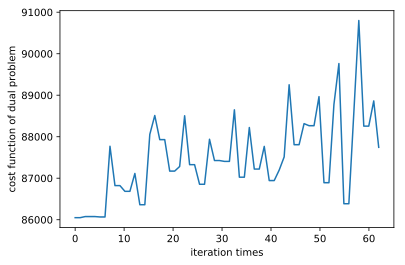

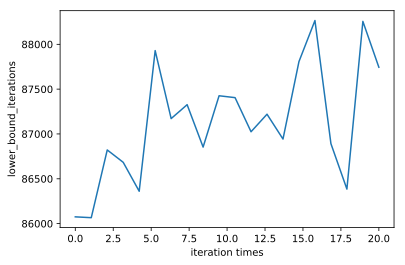

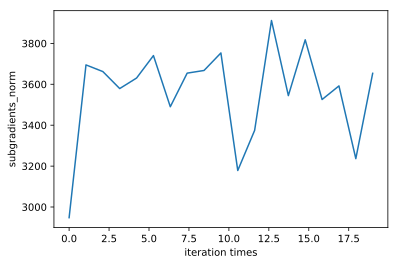

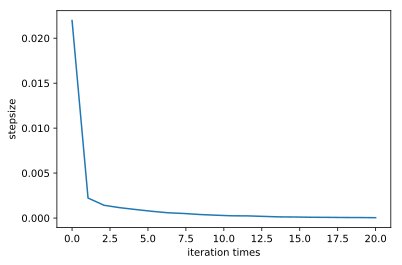

In [12]:
subproblem_lp.output_results()
subproblem_qp.output_results()
subproblem_lp.write_model()
subproblem_qp.write_model()
dual_problem.plot_results(lower_bound_iterations)
dual_problem.output_results(lower_bound_iterations, running_time)

In [150]:
class Results_Visualization():
    def __init__(self, x_opt_solution, t_opt_solution):
        self.n_position_permachine = int(n_job / n_machine_perstage)
        #self.x_opt = np.array(x_opt_solution).reshape(((n_stage - 1), n_job, n_position_permachine, n_machine_perstage))
        self.x_opt  = np.array(x_opt_solution)
        self.t_opt = np.array(t_opt_solution[0: n_stage * n_job]).reshape(n_stage*n_job)
        
    #def find_job_to_position(self):
        #x_opt_index = np.where(self.x_opt == 1)
        #self.stage_machine_job_position_combination = list(zip(x_opt_index[0], x_opt_index[1], x_opt_index[2], x_opt_index[3]))
        
    def find_job_to_position(self):
        x_opt_index = np.where(self.x_opt == 1)
        x_opt_index = x_opt_index[0]
        self.stage_machine_job_position_combination = []
        for x in x_opt_index:
            stage_index = x // (n_job)**2
            x = x % (n_job)**2
            n_job_index = x // n_job
            x = x % n_job
            machine_index = x // n_position_permachine
            position_index = x % n_position_permachine
            self.stage_machine_job_position_combination.append((stage_index, n_job_index, position_index, machine_index))
    
    def add_continuous_casting_job_to_position(self):
        continuous_casting_combination = [(2, i, i, i // n_position_permachine) for i in range(n_job)]
        self.stage_machine_job_position_combination = self.stage_machine_job_position_combination + continuous_casting_combination
    
    def transfer_list_to_dataframe(self):
        self.stage_machine_job_position_combination = pd.DataFrame(self.stage_machine_job_position_combination)
        self.stage_machine_job_position_combination.columns = ['stage', 'job', 'position', 'machine']
    
    def add_starttime_endtime(self):
        self.stage_machine_job_position_combination['start time'] = self.t_opt
        self.stage_machine_job_position_combination['end time'] = self.t_opt + np.array(processtime)
    
    def pre_process_data(self):
        self.plot_gantt_chart = self.stage_machine_job_position_combination.copy()
        self.plot_gantt_chart['machine'] += self.plot_gantt_chart['stage'].map(lambda x: x * n_machine_perstage)
        self.plot_gantt_chart = self.plot_gantt_chart.drop(columns = ['stage', 'position'])
        self.plot_gantt_chart = self.plot_gantt_chart[['machine','start time', 'end time', 'job']]
  
    def output_csvfile(self):
        self.stage_machine_job_position_combination.to_csv("scheduling results.csv",sep=',')
    
    def output_gantt_chart_csvfile(self):
        self.plot_gantt_chart.to_csv("plot_gantt_chart.csv",sep=',')

In [151]:
lower_bound_visualization = Results_Visualization(subproblem_lp.opt_solution, subproblem_qp.opt_solution)
lower_bound_visualization.find_job_to_position()
lower_bound_visualization.add_continuous_casting_job_to_position()
print(lower_bound_visualization.stage_machine_job_position_combination)

[(0, 0, 0, 0), (0, 1, 14, 2), (0, 2, 9, 2), (0, 3, 10, 2), (0, 4, 7, 2), (0, 5, 13, 2), (0, 6, 4, 2), (0, 7, 12, 1), (0, 8, 4, 1), (0, 9, 11, 1), (0, 10, 0, 1), (0, 11, 7, 1), (0, 12, 11, 0), (0, 13, 13, 0), (0, 14, 8, 0), (0, 15, 12, 0), (0, 16, 10, 0), (0, 17, 2, 0), (0, 18, 3, 0), (0, 19, 8, 1), (0, 20, 11, 2), (0, 21, 13, 1), (0, 22, 2, 1), (0, 23, 0, 2), (0, 24, 6, 1), (0, 25, 9, 1), (0, 26, 1, 2), (0, 27, 3, 2), (0, 28, 10, 1), (0, 29, 1, 1), (0, 30, 14, 1), (0, 31, 1, 0), (0, 32, 9, 0), (0, 33, 14, 0), (0, 34, 6, 0), (0, 35, 5, 0), (0, 36, 5, 1), (0, 37, 4, 0), (0, 38, 3, 1), (0, 39, 12, 2), (0, 40, 7, 0), (0, 41, 5, 2), (0, 42, 2, 2), (0, 43, 6, 2), (0, 44, 8, 2), (1, 0, 14, 0), (1, 1, 7, 2), (1, 2, 11, 2), (1, 3, 9, 2), (1, 4, 12, 2), (1, 5, 1, 2), (1, 6, 10, 2), (1, 7, 4, 2), (1, 8, 2, 2), (1, 9, 7, 1), (1, 10, 0, 2), (1, 11, 12, 1), (1, 12, 0, 1), (1, 13, 3, 2), (1, 14, 11, 1), (1, 15, 0, 0), (1, 16, 14, 1), (1, 17, 13, 0), (1, 18, 2, 1), (1, 19, 10, 1), (1, 20, 5, 1), (1, 2

In [152]:
lower_bound_visualization.transfer_list_to_dataframe()
lower_bound_visualization.add_starttime_endtime()
print(lower_bound_visualization.stage_machine_job_position_combination)
lower_bound_visualization.output_csvfile()
lower_bound_visualization.pre_process_data()
lower_bound_visualization.output_gantt_chart_csvfile()

     stage  job  position  machine   start time     end time
0        0    0         0        0     0.000286    47.822192
1        0    1        14        2    60.017505   106.628867
2        0    2         9        2   103.585587   145.473589
3        0    3        10        2   232.762445   272.387280
4        0    4         7        2   264.267816   307.425662
5        0    5        13        2   318.004842   359.673920
6        0    6         4        2   446.513732   493.486912
7        0    7        12        1   505.492456   545.738835
8        0    8         4        1   536.865232   579.537590
9        0    9        11        1   657.322794   701.490143
10       0   10         0        1   689.638144   738.351724
11       0   11         7        1   751.641375   794.706991
12       0   12        11        0   876.409311   916.355041
13       0   13        13        0   907.001773   953.583032
14       0   14         8        0   957.394211  1002.051377
15       0   15        1

In [141]:
feasible_solution_visualization = Results_Visualization(x_init, t_init)
feasible_solution_visualization.find_job_to_position()
feasible_solution_visualization.add_continuous_casting_job_to_position()
print(feasible_solution_visualization.stage_machine_job_position_combination)

[(0, 0, 0, 0), (0, 1, 1, 2), (0, 2, 2, 2), (0, 3, 3, 2), (0, 4, 4, 2), (0, 5, 5, 2), (0, 6, 6, 2), (0, 7, 8, 1), (0, 8, 8, 2), (0, 9, 9, 2), (0, 10, 10, 2), (0, 11, 11, 2), (0, 12, 13, 1), (0, 13, 14, 0), (0, 14, 14, 2), (0, 15, 0, 1), (0, 16, 1, 1), (0, 17, 2, 0), (0, 18, 3, 1), (0, 19, 4, 1), (0, 20, 5, 1), (0, 21, 6, 1), (0, 22, 7, 0), (0, 23, 8, 0), (0, 24, 9, 1), (0, 25, 10, 1), (0, 26, 11, 1), (0, 27, 12, 1), (0, 28, 13, 0), (0, 29, 14, 1), (0, 30, 0, 2), (0, 31, 1, 0), (0, 32, 2, 1), (0, 33, 3, 0), (0, 34, 4, 0), (0, 35, 5, 0), (0, 36, 6, 0), (0, 37, 7, 1), (0, 38, 7, 2), (0, 39, 9, 0), (0, 40, 10, 0), (0, 41, 11, 0), (0, 42, 12, 0), (0, 43, 12, 2), (0, 44, 13, 2), (1, 0, 0, 2), (1, 1, 1, 2), (1, 2, 2, 2), (1, 3, 3, 2), (1, 4, 4, 2), (1, 5, 5, 2), (1, 6, 6, 2), (1, 7, 8, 1), (1, 8, 8, 2), (1, 9, 10, 0), (1, 10, 11, 0), (1, 11, 11, 2), (1, 12, 13, 1), (1, 13, 14, 0), (1, 14, 14, 2), (1, 15, 0, 0), (1, 16, 1, 1), (1, 17, 2, 1), (1, 18, 3, 1), (1, 19, 4, 1), (1, 20, 5, 1), (1, 21, 

In [142]:
feasible_solution_visualization.transfer_list_to_dataframe()
feasible_solution_visualization.add_starttime_endtime()
print(feasible_solution_visualization.stage_machine_job_position_combination)
feasible_solution_visualization.output_csvfile()

     stage  job  position  machine   start time     end time
0        0    0         0        0     0.000000    47.821906
1        0    1         1        2    56.976427   103.587789
2        0    2         2        2   103.587789   145.475791
3        0    3         3        2   224.644016   264.268851
4        0    4         4        2   264.268851   307.426697
5        0    5         5        2   318.006280   359.675358
6        0    6         6        2   463.932093   510.905274
7        0    7         8        1   527.080384   567.326762
8        0    8         8        2   558.453103   601.125461
9        0    9         9        2   670.547894   714.715243
10       0   10        10        2   714.715243   763.428823
11       0   11        11        2   776.718134   819.783750
12       0   12        13        1   893.527323   933.473053
13       0   13        14        0   934.205719   980.786977
14       0   14        14        2   984.598348  1029.255513
15       0   15         

In [143]:
feasible_solution_visualization.pre_process_data()
feasible_solution_visualization.output_gantt_chart_csvfile()
print(feasible_solution_visualization.plot_gantt_chart)

     machine   start time     end time  job
0          0     0.000000    47.821906    0
1          2    56.976427   103.587789    1
2          2   103.587789   145.475791    2
3          2   224.644016   264.268851    3
4          2   264.268851   307.426697    4
5          2   318.006280   359.675358    5
6          2   463.932093   510.905274    6
7          1   527.080384   567.326762    7
8          2   558.453103   601.125461    8
9          2   670.547894   714.715243    9
10         2   714.715243   763.428823   10
11         2   776.718134   819.783750   11
12         1   893.527323   933.473053   12
13         0   934.205719   980.786977   13
14         2   984.598348  1029.255513   14
15         1     9.026620    48.533709   15
16         1    53.394823   102.131271   16
17         0    95.936245   145.695242   17
18         1   218.245926   265.588967   18
19         1   265.588967   314.219291   19
20         1   318.103864   358.445930   20
21         1   428.159134   474.